### Préparation des données

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Charger les données
customers = pd.read_excel('../../customers_data_extended.xlsx')
sales = pd.read_excel('../../sales_data_extended.xlsx')

# Calculer le churn (90 jours sans achat)
last_date = sales['Date'].max()
customer_activity = sales.groupby('Customer_ID')['Date'].max().reset_index()
customer_activity['churn'] = (last_date - customer_activity['Date']) > pd.Timedelta(days=90)

# Fusionner avec les données clients
df = pd.merge(customers, customer_activity, on='Customer_ID', how='left')
df['churn'] = df['churn'].fillna(True)  # Clients sans achat = churn

# Feature engineering
df['days_since_last_purchase'] = (last_date - df['Date']).dt.days
df['days_since_joining'] = (last_date - df['Join_Date']).dt.days

# Calculer les indicateurs d'achat
purchase_stats = sales.groupby('Customer_ID').agg(
    total_purchases=('Sale_ID', 'count'),
    avg_purchase_value=('Sale_Price', 'mean'),
    purchase_frequency=('Date', lambda x: (x.max() - x.min()).days / max(1, len(x)))
).reset_index()

df = pd.merge(df, purchase_stats, on='Customer_ID', how='left')

# Nettoyage des valeurs manquantes
df['total_purchases'] = df['total_purchases'].fillna(0)
df['avg_purchase_value'] = df['avg_purchase_value'].fillna(0)
df['purchase_frequency'] = df['purchase_frequency'].fillna(365)  # Valeur haute pour nouveaux clients

# Variables catégorielles
df = pd.get_dummies(df, columns=['Gender', 'Location', 'Preferred_Channel'], drop_first=True)

# Sélection des features
features = [
    'Age', 'Income', 'Email_Open_Rate', 'days_since_joining',
    'days_since_last_purchase', 'total_purchases', 'avg_purchase_value',
    'purchase_frequency', 'Gender_Male', 'Preferred_Channel_Online'
]

X = df[features]
y = df['churn'].astype(int)

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

C:\Users\rasam\AppData\Local\Temp\ipykernel_13684\1030584301.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['churn'] = df['churn'].fillna(True)  # Clients sans achat = churn


### Construction Modele Churn

In [12]:
# Préprocesseur
numeric_features = [f for f in features if f not in ['Gender_Male', 'Preferred_Channel_Online']]
categorical_features = ['Gender_Male', 'Preferred_Channel_Online']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])

# Modèles à comparer
models = {
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=42, scale_pos_weight=sum(y==0)/sum(y==1)))
    ]),
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
    ])
}

### Entrainement et évaluation


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.67      0.80         3

    accuracy                           0.93        15
   macro avg       0.96      0.83      0.88        15
weighted avg       0.94      0.93      0.93        15


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.67      0.80         3

    accuracy                           0.93        15
   macro avg       0.96      0.83      0.88        15
weighted avg       0.94      0.93      0.93        15


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg  

,Accuracy,Precision,Recall,F1,ROC AUC
Model,,,,,
Random Forest,0.933,1.0,0.667,0.8,1.0
XGBoost,0.933,1.0,0.667,0.8,1.0
Logistic Regression,1.000,1.0,1.000,1.0,1.0


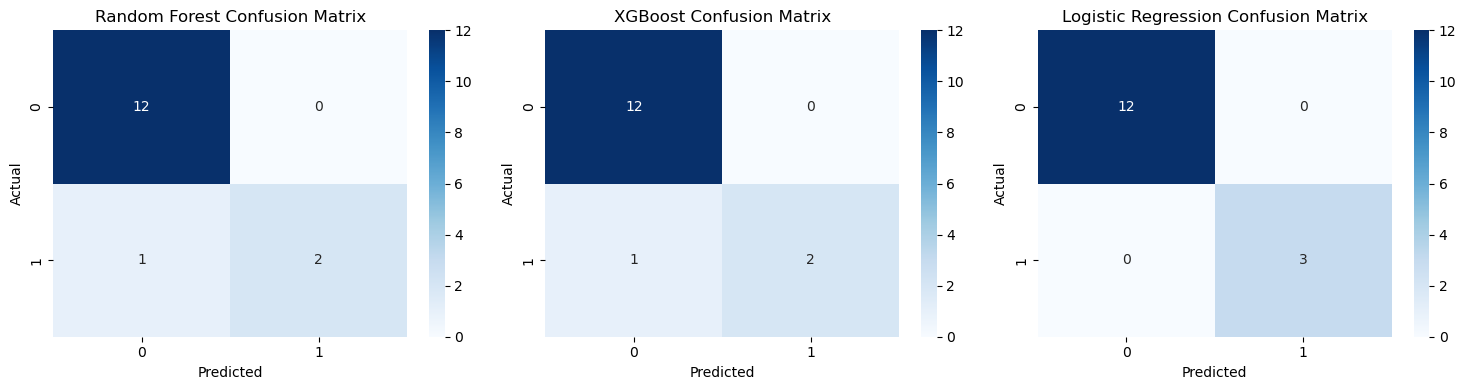

In [13]:
results = []
for name, model in models.items():
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédiction
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Métriques
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }
    results.append(metrics)
    
    # Rapport de classification
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Résultats comparatifs
results_df = pd.DataFrame(results).set_index('Model')
display(results_df.drop('Confusion Matrix', axis=1).round(3))

# Matrices de confusion
plt.figure(figsize=(15, 4))
for i, (name, metrics) in enumerate(zip(models.keys(), results)):
    plt.subplot(1, 3, i+1)
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Analyse des Features Importantes

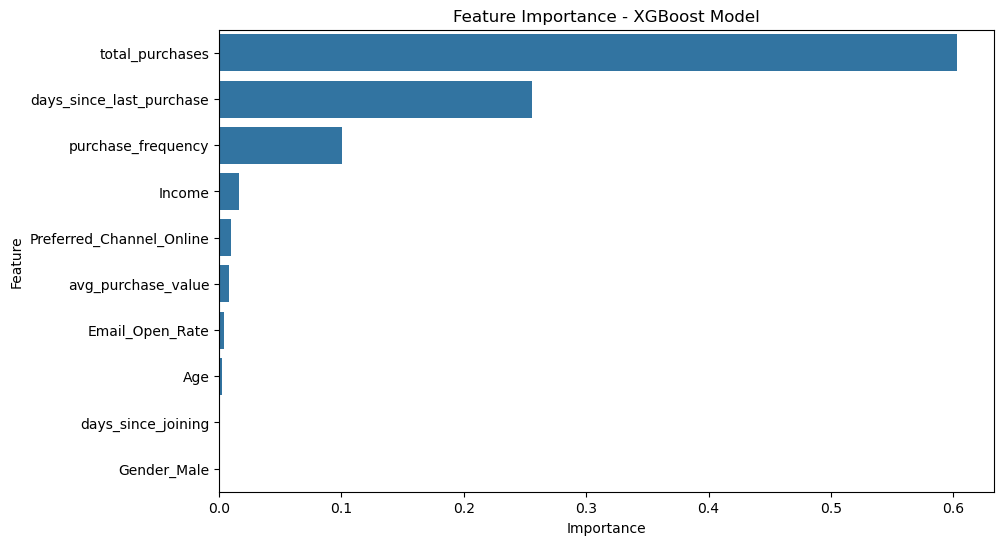

In [14]:
# Extraire le meilleur modèle (XGBoost dans notre cas)
best_model = models['XGBoost']

# Feature importance
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_names = numeric_features + categorical_features
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance - XGBoost Model')
    plt.show()

### Optimisation et Application seuil de décision

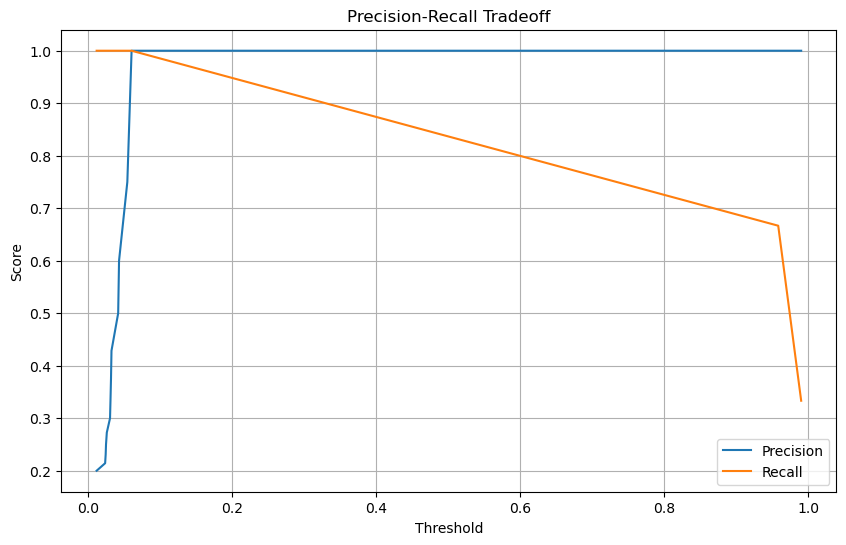

Optimal threshold: 0.06
Precision at threshold: 1.00
Recall at threshold: 1.00
F1-score at threshold: 1.00


In [15]:
from sklearn.metrics import precision_recall_curve

# Courbe Precision-Recall
y_proba = best_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.grid()
plt.show()

# Sélection du seuil optimal (exemple: maximise F1-score)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Precision at threshold: {precision[optimal_idx]:.2f}")
print(f"Recall at threshold: {recall[optimal_idx]:.2f}")
print(f"F1-score at threshold: {f1_scores[optimal_idx]:.2f}")


Performance avec seuil optimal:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



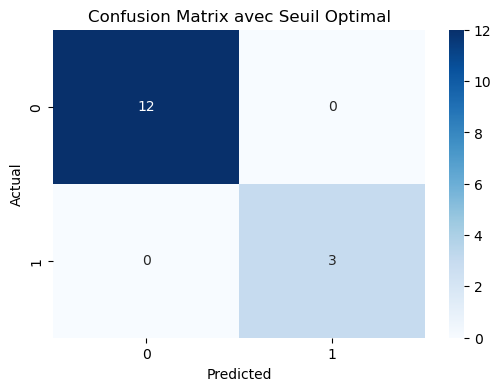

In [16]:
# Application du seuil optimal
y_pred_optimal = (best_model.predict_proba(X_test)[:, 1] >= optimal_threshold).astype(int)

print("\nPerformance avec seuil optimal:")
print(classification_report(y_test, y_pred_optimal))

# Matrice de confusion optimale
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_optimal), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix avec Seuil Optimal')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Recommandations Strategiques

In [17]:
# Segmentation des clients
df['churn_probability'] = best_model.predict_proba(df[features])[:, 1]
df['churn_risk'] = pd.qcut(df['churn_probability'], q=3, labels=['Low', 'Medium', 'High'])

# Analyse par segment
segment_analysis = df.groupby('churn_risk').agg({
    'Customer_ID': 'count',
    'churn_probability': 'mean',
    'Income': 'mean',
    'total_purchases': 'mean',
    'days_since_last_purchase': 'mean'
}).rename(columns={'Customer_ID': 'count'})

print("Analyse des segments de risque:")
display(segment_analysis.round(2))

# Recommandations
print("\nRecommandations par segment:")
print("1. Risque Élevé (High):")
print("- Campagnes de rétention personnalisées")
print("- Offres spéciales pour réactiver")
print("- Contact direct par service client")

print("\n2. Risque Moyen (Medium):")
print("- Programmes de fidélisation")
print("- Contenu éducatif sur la valeur du service")
print("- Enquêtes de satisfaction")

print("\n3. Risque Faible (Low):")
print("- Programmes de recommandation (parrainage)")
print("- Upselling/cross-selling")
print("- Maintenir l'expérience client actuelle")

Analyse des segments de risque:


C:\Users\rasam\AppData\Local\Temp\ipykernel_13684\2869011566.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = df.groupby('churn_risk').agg({


,count,churn_probability,Income,total_purchases,days_since_last_purchase
churn_risk,,,,,
Low,17,0.02,84854.06,3.24,16.59
Medium,15,0.04,83787.93,1.87,33.47
High,17,0.60,76542.35,1.00,110.80



Recommandations par segment:
1. Risque Élevé (High):
- Campagnes de rétention personnalisées
- Offres spéciales pour réactiver
- Contact direct par service client

2. Risque Moyen (Medium):
- Programmes de fidélisation
- Contenu éducatif sur la valeur du service
- Enquêtes de satisfaction

3. Risque Faible (Low):
- Programmes de recommandation (parrainage)
- Upselling/cross-selling
- Maintenir l'expérience client actuelle


### Export des prédictions

In [18]:
# Création du fichier final
output = df[['Customer_ID', 'Name', 'Age', 'Income', 'churn_probability', 'churn_risk']]
output = output.sort_values('churn_probability', ascending=False)

# Export en CSV
output.to_csv('customer_churn_predictions.csv', index=False)

print("Prédictions exportées avec succès. Nombre de clients par segment:")
print(output['churn_risk'].value_counts())

Prédictions exportées avec succès. Nombre de clients par segment:
churn_risk
Low       17
High      17
Medium    15
Name: count, dtype: int64
